In [48]:
# Library Imports 
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
importlib.reload(mf)
from collections import defaultdict
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve

## FUNCTIONS ##

In [4]:
def read_B_field(file_name):
    match = re.search(r'fld_([0-9.]+)', file_name)
    if match: 
        
        b_field = float(match.group(1).strip("."))
        return b_field
    else: 
        print("Error: field value not found in filename.")

## Data Path ## 

In [5]:
data_path = "data_optics/data_fergus/2025-03-26_IH_line_magnet_ramp_sit2/"
data_file ="data_optics/data_fergus/2025-03-26_IH_line_magnet_ramp_sit2/2025-03-26 18-56-17_freq_194.81246_rng_36.5143_gain_30_fld_0.0.csv"

## SINGLE SPECTRUM ##

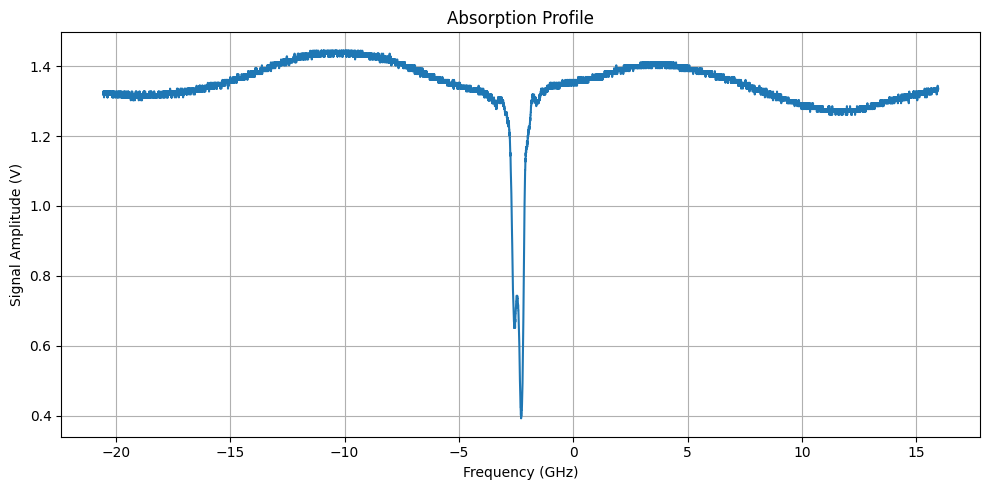

In [6]:

# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

# Plot absorption profile
plt.figure(figsize=(10, 5))
plt.plot(freq_axis_GHz, voltage)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Signal Amplitude (V)")
plt.title("Absorption Profile")
plt.grid(True)
plt.tight_layout()
plt.show()




## Fabrey-Perot Filtering ## 

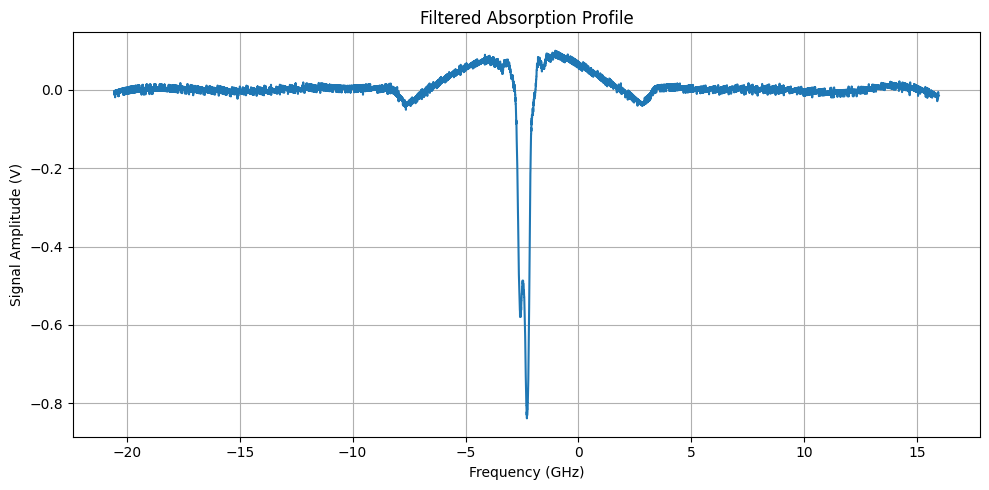

In [53]:
from scipy.signal import savgol_filter

background = savgol_filter(voltage, window_length=3001, polyorder=3)
cleaned_signal = voltage - background


# Plot absorption profile
plt.figure(figsize=(10, 5))
plt.plot(freq_axis_GHz, cleaned_signal)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Signal Amplitude (V)")
plt.title("Filtered Absorption Profile")
plt.grid(True)
plt.tight_layout()
plt.show()

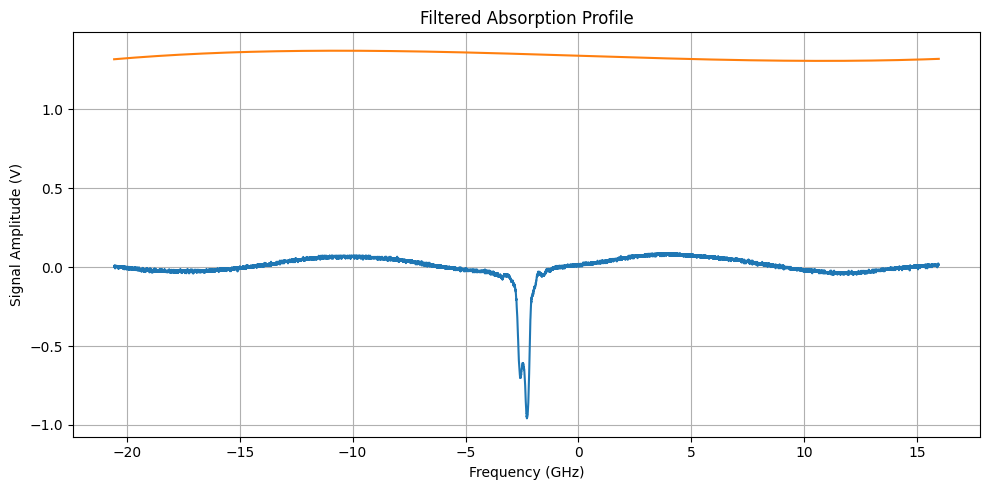

In [46]:
import numpy as np
from scipy.optimize import curve_fit

# Define a low-order polynomial
def poly_bg(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

# Mask the dip region (customize these bounds)
mask = (freq_axis_GHz < -2) | (freq_axis_GHz > 2)
popt, _ = curve_fit(poly_bg, freq_axis_GHz[mask], voltage[mask])

# Subtract background
background = poly_bg(freq_axis_GHz, *popt)
cleaned_signal = voltage - background

# Plot absorption profile
plt.figure(figsize=(10, 5))
plt.plot(freq_axis_GHz, cleaned_signal)
plt.plot(freq_axis_GHz, background)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Signal Amplitude (V)")
plt.title("Filtered Absorption Profile")
plt.grid(True)
plt.tight_layout()
plt.show()


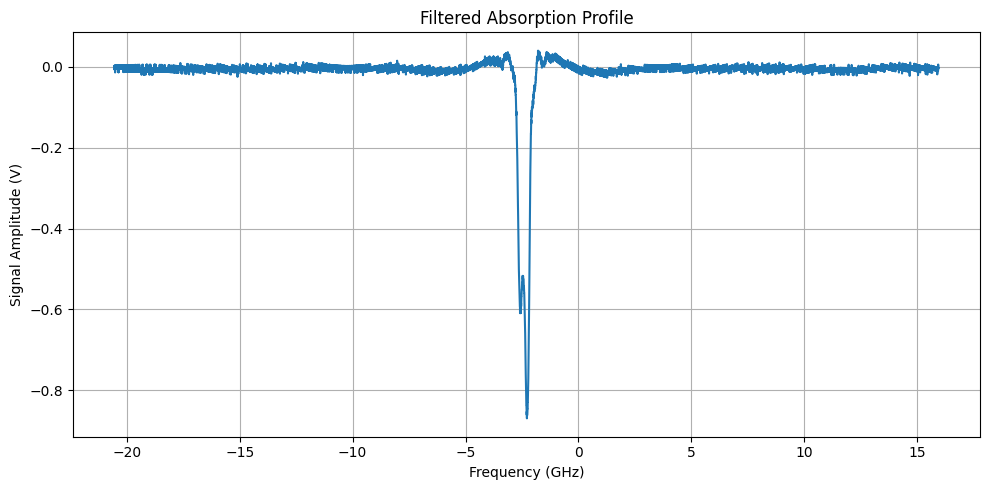

In [47]:
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als(y, lam=1e9, p=0.9, niter=20):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z


background = baseline_als(voltage)
cleaned_signal = voltage - background


# Plot absorption profile
plt.figure(figsize=(10, 5))
plt.plot(freq_axis_GHz, cleaned_signal)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Signal Amplitude (V)")
plt.title("Filtered Absorption Profile")
plt.grid(True)
plt.tight_layout()
plt.show()

## 2D SPECTRA W MAGNETIC FIELD ## 

In [7]:
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]


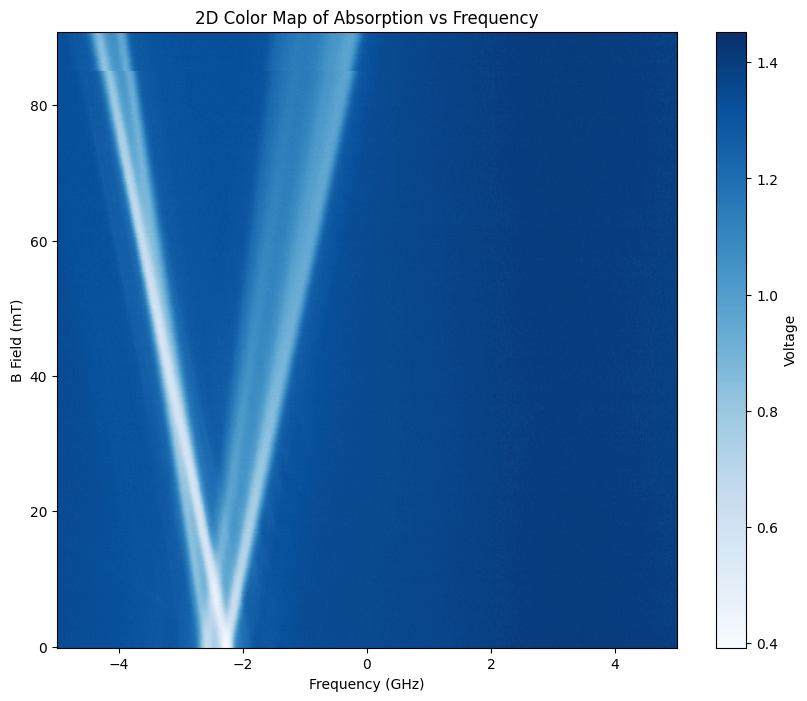

In [57]:
# plot 
plt.figure(figsize=(10,8))
plt.pcolormesh(freq_axis_GHz, fields*1000, voltages, shading='auto', cmap='Blues')
#plt.ylim([80,90])
plt.xlim([-5, 5])
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")
plt.show()


## FILTERED 2D ## 

[1.3188734 1.3272207 1.3272207 ... 1.335568  1.335568  1.335568 ]


In [68]:
cleaned_signals =[] 
def baseline_als(y, lam=1e9, p=0.9, niter=20):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2],shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

for signal in voltages:
    background = baseline_als(signal)
    cleaned_signal = signal - background
    #cleaned_signal = np.log(cleaned_signal)
    cleaned_signals.append(cleaned_signal)

cleaned_signals = np.array(cleaned_signals)

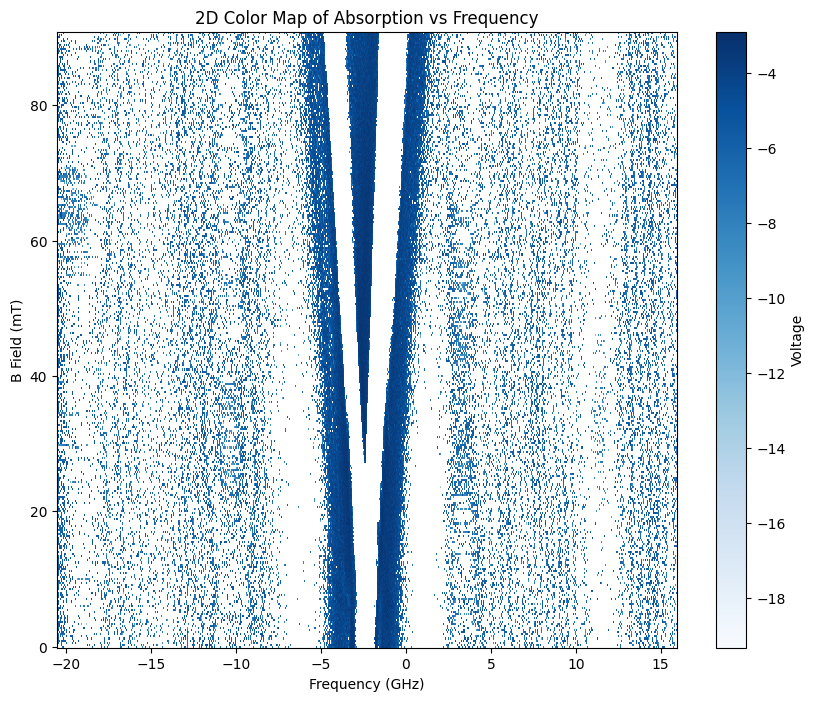

In [67]:

# plot 
plt.figure(figsize=(10,8))
plt.pcolormesh(freq_axis_GHz, fields*1000, cleaned_signals, shading='auto', cmap='Blues')
#plt.ylim([80,90])
#plt.xlim([-5, 5])
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")
plt.show()

## Linewidths ## 

-2.1502708241141306
-2.674996214366208

######## Absorption Dip Features ########
Min Frequency (GHz): -2.282370
FWHM (GHz): 0.524725
Baseline (max signal): 1.444083
Dip Value (min signal): 0.392323
Absorption Depth: 1.051760
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -12.420945
FWHM (GHz): 0.277040
Baseline (max signal): 1.444083
Dip Value (min signal): 1.402346
Absorption Depth: 0.041736
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -12.167756
FWHM (GHz): 0.011008
Baseline (max signal): 1.444083
Dip Value (min signal): 1.410694
Absorption Depth: 0.033389
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -12.145739
FWHM (GHz): 0.073388
Baseline (max signal): 1.444083
Dip Value (min signal): 1.410694
Absorption Depth: 0.033389
#########################################


######## Absorption Dip Features ####

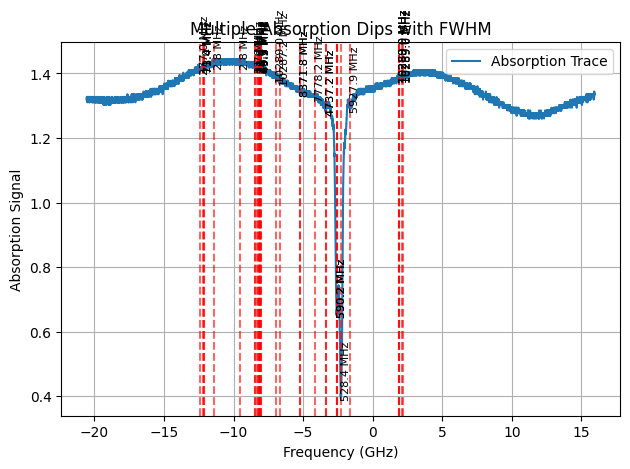

In [10]:
## SINGLE SPECTRUM ## 
# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.018, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([-5,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -2.381436 GHz
  FWHM:   814.47 MHz
  Depth:  1.2563
#########################################



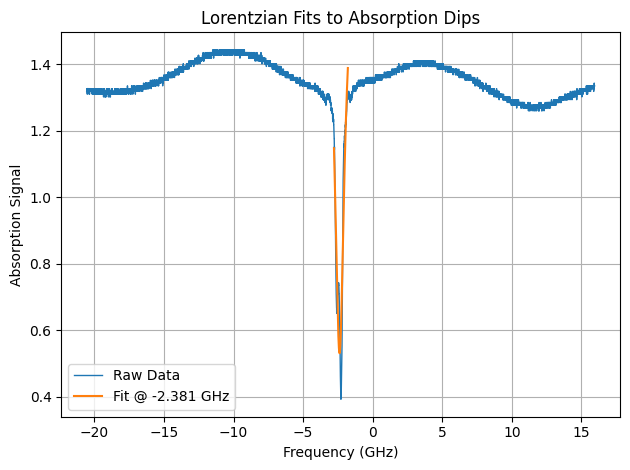

In [11]:
## Lorentzian Fits ##
fits = mf.fit_lorentzian_dip(freq_axis_GHz, voltage, window_width=1, min_prominence=0.14, to_print=True)

plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

for f in fits:
    if len(fits)> 5: 
        raise ValueError("WARNING TOO MANY FITS")
    plt.plot(f["f_fit"], f["fit_curve"], label=f"Fit @ {f['f_dip']:.3f} GHz")

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([-5,5])
plt.title("Lorentzian Fits to Absorption Dips")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Collect Linewidths for All data ## 

In [28]:
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]

In [31]:
linewidths = [] 
for volt in voltages: 
    features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=volt, min_prominence=0.2, to_print=True)
    for f in features: 
        linewidths.append(float(f["FWHM"]))
print(linewidths)



######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.119019
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.012117
FWHM (GHz): 0.591647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.411390
Absorption Depth: 0.946197
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.080040
FWHM (GHz): 0.804530
Baseline (max signal): 1.371300
Dip Value (min signal): 0.479955
Absorption Depth: 0.891345
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.068981
FWHM (GHz

## Linewidth Change Estimate Start Finish ## 

0.2480385088103575
-0.17956946557663722

######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.427608
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.119019
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################



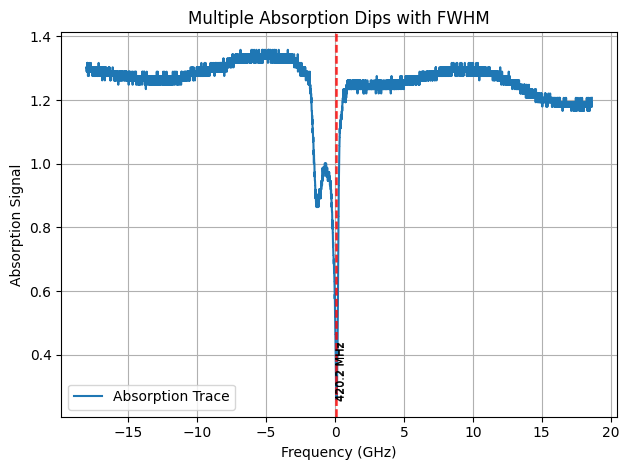

2.618313746145174
-2.8631781324191645

######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 5.481492
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -2.177531
FWHM (GHz): 0.417471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.767928
Absorption Depth: 0.589659
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 0.596255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



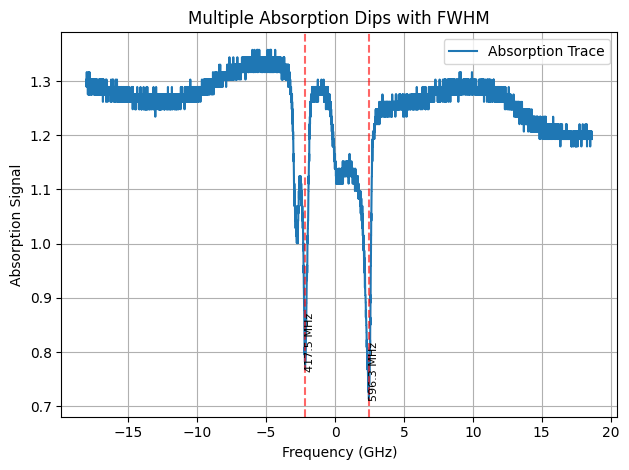

In [39]:
## SINGLE SPECTRUM 1  ## 

data_file1 ="data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 19-57-37_freq_195.11847_rng_36.6852_gain_30_fld_0.csv"


# Step 1: read CSV
data1 = pd.read_csv(data_file1, header=None)

# Extract time, signal, and frequency
time_axis1 = data1.iloc[0].values.astype(float)
voltage1 = data1.iloc[1].values.astype(float)
freq_axis1 = data1.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz1 = freq_axis1 / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz1, y_data=voltage1, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz1, signal=voltage1, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz1, voltage1, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage1[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## SINGLE SPECTRUM 2 ## 
data_file2 ="data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 19-57-37_freq_195.11847_rng_36.6852_gain_30_fld_0.csv"


# Step 1: read CSV
data2 = pd.read_csv(data_file2, header=None)

# Extract time, signal, and frequency
time_axis2 = data2.iloc[0].values.astype(float)
voltage2 = data2.iloc[1].values.astype(float)
freq_axis2 = data2.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz2 = freq_axis2 / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz2, y_data=voltage2, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz2, signal=voltage2, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz2, voltage2, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage2[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



0.6166660729370783
-0.5813735104747628

######## Absorption Dip Features ########
Min Frequency (GHz): -0.268040
FWHM (GHz): 1.198040
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.268040
FWHM (GHz): 0.457098
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.256981
FWHM (GHz): 0.457098
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.506078
FWHM (GHz): 0.379686
Baseline (max signal): 1.357587
Dip Value (min signal): 0.617085
Absorption Depth: 0.740502
#########################################



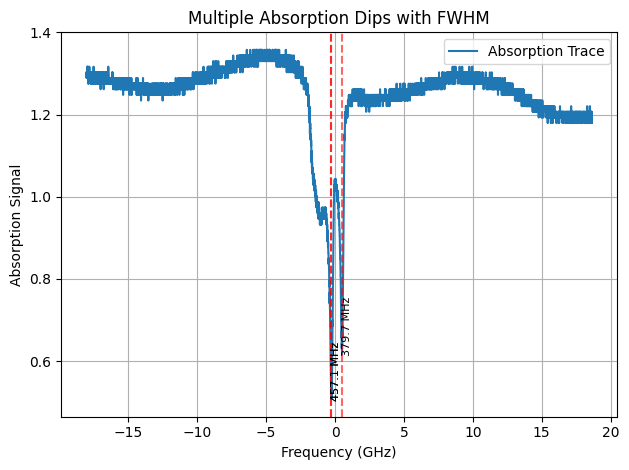

2.618313746145174
-2.8631781324191645

######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 5.481492
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -2.177531
FWHM (GHz): 0.417471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.767928
Absorption Depth: 0.589659
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 0.596255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



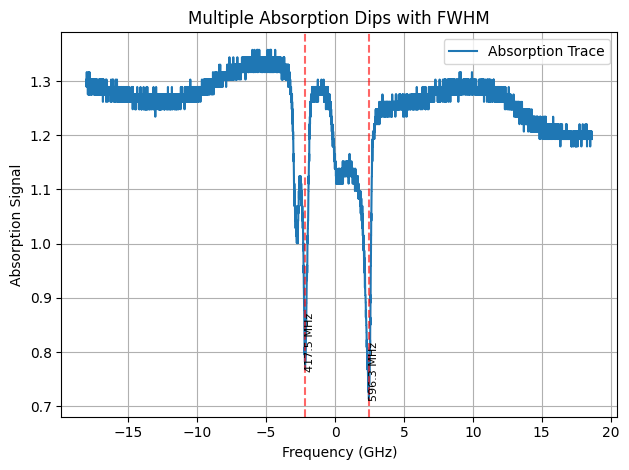

In [40]:
## SINGLE SPECTRUM 1  ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 13-46-29_freq_195.11758_rng_36.6821_gain_30_fld_0.01456.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## SINGLE SPECTRUM 2 ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 14-10-25_freq_195.11758_rng_36.6821_gain_30_fld_0.08736.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



## Linewidth Vs Central Frequency non-Lorentzian ## 

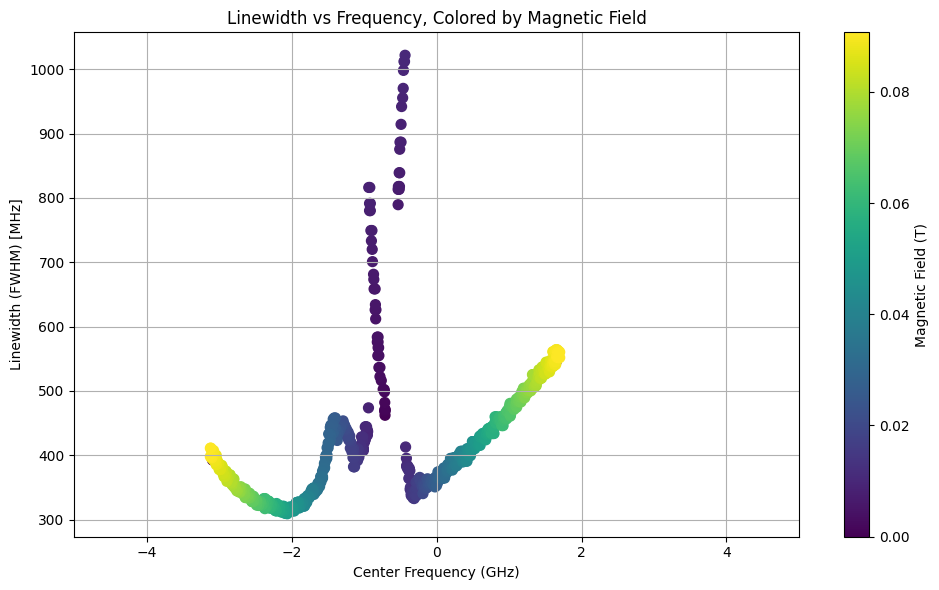

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# data_files = sorted(glob.glob(data_path + "*"))

# voltages = [] 
# fields = []

# Storage for linewidth analysis
all_f_dips = []
all_fwhms = []
all_B_fields = []

# for file in data_files: 
#     data = pd.read_csv(file, header=None)
#     time_axis = data.iloc[0].values.astype(float)
#     voltage = data.iloc[1].values.astype(float)
#     freq_axis = data.iloc[2].values.astype(float)
#     freq_axis_GHz = freq_axis / 1e9

#     B_field = read_B_field(file_name=file)
#     fields.append(B_field)
#     voltages.append(voltage)

# fields = np.array(fields)
# voltages = np.array(voltages)

# sort_idx = np.argsort(fields)
# fields = fields[sort_idx]
# voltages = voltages[sort_idx]

# === Extract and store linewidth features === #
for voltage, B in zip(voltages, fields): 
    features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=False)

    # Plot per-spectrum trace (optional)
    # plt.figure(figsize=(10, 4))
    # plt.plot(freq_axis_GHz, voltage, label=f'B = {B:.4f} T')
    for f in features:
        f_dip = f["f_dip"]
        fwhm = f["FWHM"]
        index = f["index"]

        all_f_dips.append(f_dip)
        all_fwhms.append(fwhm * 1e3)      # Convert FWHM to MHz
        all_B_fields.append(B)

        # plt.axvline(f_dip, color='r', linestyle='--', alpha=0.6)
        # plt.text(f_dip, voltage[index], f"{fwhm*1e3:.1f} MHz", rotation=90, fontsize=8)

    # plt.xlabel("Frequency (GHz)")
    # plt.ylabel("Absorption Signal")
    # plt.title("Absorption Dips with FWHM")
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

# === Final Plot: Linewidth vs Frequency, colored by B-field === #
plt.figure(figsize=(10, 6))
scatter = plt.scatter(all_f_dips, all_fwhms, c=all_B_fields, cmap='viridis', s=50) # edgecolor='k'
cbar = plt.colorbar(scatter)
cbar.set_label("Magnetic Field (T)")

plt.xlabel("Center Frequency (GHz)")
plt.ylabel("Linewidth (FWHM) [MHz]")
plt.xlim([-5,5])
plt.title("Linewidth vs Frequency, Colored by Magnetic Field")
plt.grid(True)
plt.tight_layout()
plt.show()


## LORENTZIAN VERSION ## 

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

data_files = sorted(glob.glob(data_path + "*"))

# voltages = [] 
# fields = []

# Storage for linewidth analysis
all_f_dips = []
all_fwhms = []
all_B_fields = []

# for file in data_files: 
#     data = pd.read_csv(file, header=None)
#     time_axis = data.iloc[0].values.astype(float)
#     voltage = data.iloc[1].values.astype(float)
#     freq_axis = data.iloc[2].values.astype(float)
#     freq_axis_GHz = freq_axis / 1e9

#     B_field = read_B_field(file_name=file)
#     fields.append(B_field)
#     voltages.append(voltage)

# fields = np.array(fields)
# voltages = np.array(voltages)

# sort_idx = np.argsort(fields)
# fields = fields[sort_idx]
# voltages = voltages[sort_idx]

# === Extract and store linewidth features === #
for voltage, B in zip(voltages, fields): 
    features = mf.fit_lorentzian_dip(freq_axis_GHz, voltage, window_width=2, min_prominence=0.2, to_print=False)
    
    # Plot per-spectrum trace (optional)
    # plt.figure(figsize=(10, 4))

    # plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

    for f in features:
        if len(features)> 10: 
            raise ValueError("WARNING TOO MANY FITS")
        # plt.plot(f["f_fit"], f["fit_curve"], label=f"Fit @ {f['f_dip']:.3f} GHz" + f' B = {B:.4f} T')
        f_dip = f["f_dip"]
        fwhm = f["FWHM"]
        all_f_dips.append(f_dip)
        all_fwhms.append(fwhm * 1e3)      # Convert FWHM to MHz
        all_B_fields.append(B)

    # plt.xlabel("Frequency (GHz)")
    # plt.ylabel("Absorption Signal")
    # #plt.xlim([-5,5])
    # plt.title("Lorentzian Fits to Absorption Dips")
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()



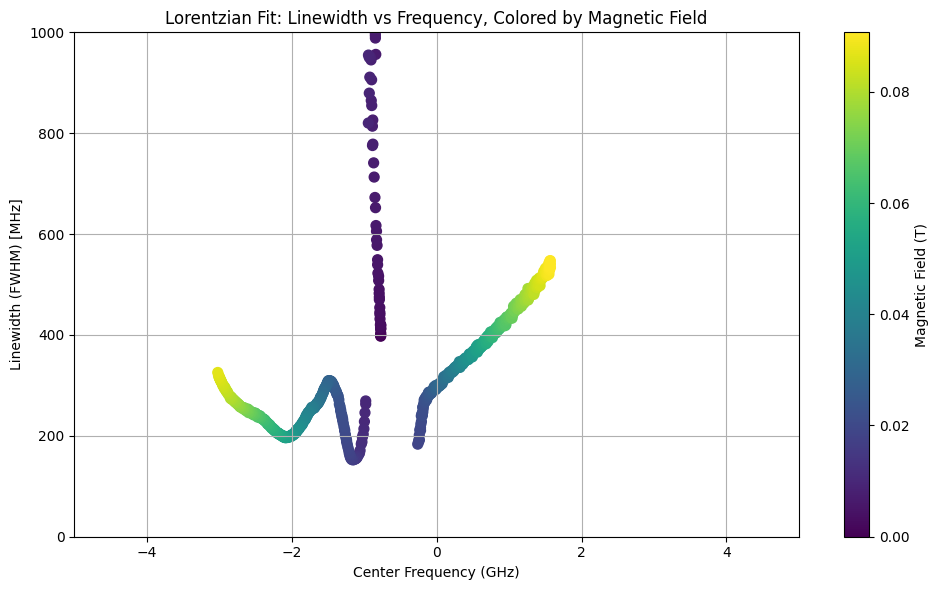

In [33]:
# === Final Plot: Linewidth vs Frequency, colored by B-field === #
plt.figure(figsize=(10, 6))
scatter = plt.scatter(all_f_dips, all_fwhms, c=all_B_fields, cmap='viridis', s=50) #edgecolor='k'
cbar = plt.colorbar(scatter)
cbar.set_label("Magnetic Field (T)")

plt.xlabel("Center Frequency (GHz)")
plt.ylabel("Linewidth (FWHM) [MHz]")
plt.xlim([-5,5])
plt.ylim([0,1000])
plt.title("Lorentzian Fit: Linewidth vs Frequency, Colored by Magnetic Field")
plt.grid(True)
plt.tight_layout()
plt.show()